# **Email Classification using Transformer-Encoder**

In [1]:
!pip install torch==2.1.0
!pip install -q torchtext==0.16.0
!pip install -q torchdata==0.7.0

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manyl

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **1. Transformer Encoder**

### **1.1. Embedding**

In [3]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, device='cpu'):
        super(TokenAndPositionEmbedding, self).__init__()
        self.device = device
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.position_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=embedding_dim)

    def forward(self, x):
        batch_size, seq_length = x.size()
        position = torch.arange(0, seq_length, dtype=torch.long).expand(batch_size, seq_length).to(self.device)
        o1 = self.token_embedding(x)
        o2 = self.position_embedding(position)
        return o1 + o2



### **1.2. Transformer Encoder**

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=ff_dim, out_features=embed_dim),
            nn.Dropout(p=dropout)
        )
        self.layernorm1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, query, key, value):
        attn_output, attn_output_weights = self.attention(query=query, key=key, value=value)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2



### **1.3 Transformer Encoder Classifier**

In [5]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

## **2. Experiment**

### **2.1 Dataset**

In [6]:
!gdown --id 1N7rk-kfnDFIGMeX0ROVTjKh71gcgx-7R

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1N7rk-kfnDFIGMeX0ROVTjKh71gcgx-7R
To: /content/2cls_spam_text_cls.csv
100% 486k/486k [00:00<00:00, 69.7MB/s]


In [7]:
import os
import pandas as pd

In [8]:
def load_data_from_path(file_path):
    df =  pd.read_csv(file_path)
    df['Category'] = df['Category'].map({'spam': 1, 'ham': 0})
    return df

In [9]:
file_path = '/content/2cls_spam_text_cls.csv'
df = load_data_from_path(file_path)
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [10]:
from sklearn.model_selection import train_test_split
VAL_SIZE = 0.2
TEST_SIZE = 0.125
SEED = 42
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=SEED)

In [11]:
print('train: ', train_df.shape)
print('valid: ', valid_df.shape)
print('test: ', test_df.shape)

train:  (3900, 2)
valid:  (975, 2)
test:  (697, 2)


### **2.2 Preprocessing**
Text cleaning

In [12]:
import re
import string

def preprocess_text(text):

    # Remove URLs https://www.
    ulr_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = ulr_pattern.sub(r'', text)

    # Remove HTML tags
    html_pattern = re.compile('<.*?>')
    text = html_pattern.sub(r'', text)
    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [13]:
train_df['preprocess_sentence'] = [preprocess_text(row['Message']) for index, row in train_df.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['Message']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence']  = [preprocess_text(row['Message']) for index, row in test_df.iterrows()]

In [14]:
test_df.head()

,Category,Message,preprocess_sentence
3245,0,Squeeeeeze!! This is christmas hug.. If u lik ...,squeeeeeze this is christmas hug if u lik my f...
944,0,And also I've sorta blown him off a couple tim...,and also i ve sorta blown him off a couple tim...
1044,0,Mmm thats better now i got a roast down me! i...,mmm thats better now i got a roast down me id...
2484,0,Mm have some kanji dont eat anything heavy ok,mm have some kanji dont eat anything heavy ok
812,0,So there's a ring that comes with the guys cos...,so there s a ring that comes with the guys cos...


###**2.3. Representation**

In [15]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [16]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('basic_english')
vocab_size = 10000
vocab = build_vocab_from_iterator(
    iterator=yield_tokens(sentences=train_df['preprocess_sentence'], tokenizer=tokenizer),
    specials=['<unk>', '<pad>'],
    max_tokens=vocab_size
)
vocab.set_default_index(vocab['<unk>'])

In [17]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocab(tokenizer(sentence))
        label = row['Category']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [18]:
test_dataset[0]

([0,
  40,
  10,
  981,
  2562,
  41,
  7,
  1558,
  11,
  0,
  523,
  2562,
  12,
  102,
  41,
  7,
  31,
  7,
  86,
  1255,
  7,
  86,
  0,
  7,
  86,
  29,
  618,
  1329,
  279,
  1875,
  7],
 0)

### **2.4 Dataloader**

In [19]:
seq_length = 100
def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]*(seq_length-len(sentence))) if len(sentence)<seq_length else sentence[:seq_length]
        for sentence in sentences
    ]
    return torch.tensor(encoded_sentences, dtype=torch.int64), torch.tensor(labels, dtype=torch.int64)


In [20]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

In [21]:
sample = next(iter(test_dataloader))
sample[0].shape

torch.Size([32, 100])

In [22]:
sample

(tensor([[  67,    6, 2451,  ...,    0,    0,    0],
         [  72,    4, 1698,  ...,    0,    0,    0],
         [ 145,  104,    2,  ...,    0,    0,    0],
         ...,
         [ 236,  217,    2,  ...,    0,    0,    0],
         [  39, 1988,  220,  ...,    0,    0,    0],
         [   0,  144, 3587,  ...,    0,    0,    0]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 1]))

### **2.5 Trainer**

In [23]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device='cpu', epoch=0, log_interval=10):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()
    for idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        total_acc += (output.argmax(1) == y).sum().item()
        total_count += y.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc  = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [24]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [25]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device='cpu'):
    train_losses = []
    eval_losses = []
    train_accs = []
    eval_accs = []
    best_loss_eval = 100
    times = []

    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_dataloader=train_dataloader,
            device=device,
            epoch=epoch
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(
            model=model,
            criterion=criterion,
            valid_dataloader=valid_dataloader,
            device=device
        )
        eval_losses.append(eval_loss)
        eval_accs.append(eval_acc)

        # Save best model
        if eval_loss < best_loss_eval:
            best_loss_eval = eval_loss
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
        times.append(time.time() - epoch_start_time)

        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)
    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics



In [28]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

### **2.6 Model Config**

In [29]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_heads = 4
ff_dim = 128
dropout=0.1


### **2.7 Training**

In [32]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device
)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'transformer_encoder_cls'


In [33]:
model, metrics = train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device)

| epoch   1 |    10/  122 batches | accuracy    0.795
| epoch   1 |    20/  122 batches | accuracy    0.881
| epoch   1 |    30/  122 batches | accuracy    0.881
| epoch   1 |    40/  122 batches | accuracy    0.887
| epoch   1 |    50/  122 batches | accuracy    0.894
| epoch   1 |    60/  122 batches | accuracy    0.906
| epoch   1 |    70/  122 batches | accuracy    0.938
| epoch   1 |    80/  122 batches | accuracy    0.938
| epoch   1 |    90/  122 batches | accuracy    0.931
| epoch   1 |   100/  122 batches | accuracy    0.941
| epoch   1 |   110/  122 batches | accuracy    0.931
| epoch   1 |   120/  122 batches | accuracy    0.953
-----------------------------------------------------------
| End of epoch   1 | Time:  0.86s | Train Accuracy    0.929 | Train Loss    0.241 | Valid Accuracy    0.945 | Valid Loss    0.184 
-----------------------------------------------------------
| epoch   2 |    10/  122 batches | accuracy    0.974
| epoch   2 |    20/  122 batches | accuracy   

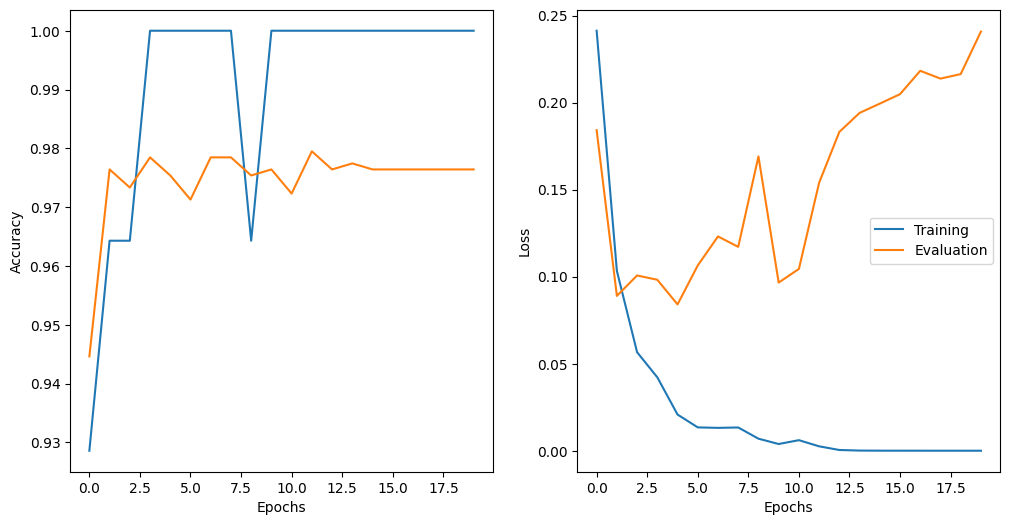

In [34]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)